<a href="https://colab.research.google.com/github/xixilili/MSDS_458_Public/blob/master/MSDS458_Assignment_03/MSDS458_Assignment_03_Experiment_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiments C: LSTM: 
Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load Package

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Load and Process Data

In [3]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-19 08:20:33.884206: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0219 08:20:33.884550 139965607896960 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0219 08:20:33.885999 139965607896960 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0219 08:20:33.894124 139965607896960 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0219 08:20:33.894530 139965607896960 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Explore Vocab

In [5]:
def explore_vocab(train_dataset,encoder):
  doc_sizes = []
  corpus = []
  for example, _ in train_dataset.as_numpy_iterator():
    enc_example = encoder(example)
    doc_sizes.append(len(enc_example))
    corpus+=list(enc_example.numpy())
  return  corpus, doc_sizes

### Compile, Train Model

In [6]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [7]:
import datetime as dt

def compile_train_model(model, epoch):
  #compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model  
  history = model.fit(train_dataset
                    ,epochs = epoch
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


  #evaluate model
  loss, accuracy = model.evaluate(test_dataset)
  print('test set accuracy: ', accuracy * 100)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs_setting'] = epoch  
  result['epochs_actual'] = epochs    

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs'.format(namestr(model, globals()), epoch))   
  plt.show()  

  return result

## LSTM

### Encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary());

In [9]:
corpus, doc_sizes = explore_vocab(train_dataset,encoder)

In [10]:
vocab = np.array(encoder.get_vocabulary())
num_vocab_words_in_corpus =len(vocab)

num_words =len(corpus)
num_articles =len(doc_sizes)
min_token_in_a_article = min(doc_sizes)
max_token_in_a_article = max(doc_sizes)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

1000
114000
1782
16
64


### Create Model

In [11]:
LSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.LSTM(units = 64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])


In [12]:
Multiplelayer_LSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.LSTM(units = 64, return_sequences=True)                              
                              ,tf.keras.layers.LSTM(units = 64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [13]:
BidirectionalLSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) 
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [14]:
Multiplelayer_BidirectionalLSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [15]:
Multiplelayer_BidirectionalLSTM_Dropout = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)                              
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

Recurrent dropout—This is a variant of dropout, used to fight overfitting in recurrent layers.
Stacking recurrent layers—This increases the representational power of the model (at the cost of higher computational loads).
Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### LSTM

Epoch 1/200
1782/1782 [==============================] - 160s 87ms/step - loss: 0.8812 - accuracy: 0.6126 - val_loss: 0.6097 - val_accuracy: 0.7793
Epoch 2/200
1782/1782 [==============================] - 151s 85ms/step - loss: 0.5112 - accuracy: 0.8192 - val_loss: 0.4661 - val_accuracy: 0.8362
Epoch 3/200
1782/1782 [==============================] - 161s 90ms/step - loss: 0.4539 - accuracy: 0.8385 - val_loss: 0.4474 - val_accuracy: 0.8457
Epoch 4/200
1782/1782 [==============================] - 156s 88ms/step - loss: 0.4380 - accuracy: 0.8429 - val_loss: 0.4354 - val_accuracy: 0.8453
Epoch 5/200
1782/1782 [==============================] - 157s 88ms/step - loss: 0.4225 - accuracy: 0.8492 - val_loss: 0.4177 - val_accuracy: 0.8525
Epoch 6/200
1782/1782 [==============================] - 153s 86ms/step - loss: 0.4065 - accuracy: 0.8545 - val_loss: 0.4154 - val_accuracy: 0.8497
Epoch 7/200
1782/1782 [==============================] - 154s 87ms/step - loss: 0.3951 - accuracy: 0.8587 - val_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

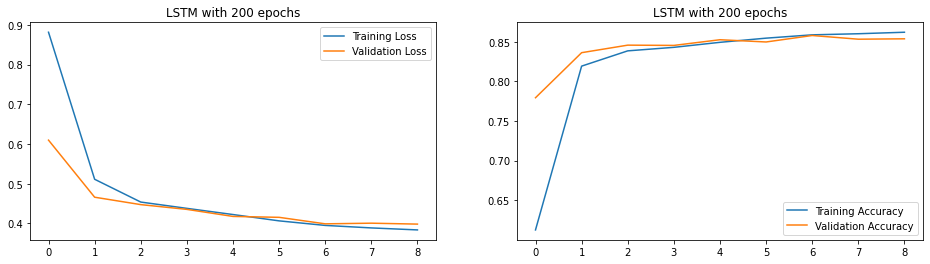

In [16]:
result_LSTM = compile_train_model(LSTM, 200)

In [17]:
result_LSTM['vocab_size'] = VOCAB_SIZE 
result_LSTM['num_words'] = num_words 
result_LSTM['num_articles'] = num_articles
result_LSTM['min_token_in_a_article'] = min_token_in_a_article 
result_LSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['LSTM']   
result_LSTM.insert(loc=0, column='Model', value=new_col)

In [18]:
prev_results_df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/resultsB.pkl')
assignment_result_table = prev_results_df.append(result_LSTM,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


### Multiplelayer LSTM

Epoch 1/200
1782/1782 [==============================] - 304s 164ms/step - loss: 0.7062 - accuracy: 0.7214 - val_loss: 0.4947 - val_accuracy: 0.8273
Epoch 2/200
1782/1782 [==============================] - 290s 163ms/step - loss: 0.4763 - accuracy: 0.8284 - val_loss: 0.4664 - val_accuracy: 0.8358
Epoch 3/200
1782/1782 [==============================] - 298s 167ms/step - loss: 0.4546 - accuracy: 0.8350 - val_loss: 0.4471 - val_accuracy: 0.8410
Epoch 4/200
1782/1782 [==============================] - 292s 164ms/step - loss: 0.4394 - accuracy: 0.8412 - val_loss: 0.4428 - val_accuracy: 0.8422
Epoch 5/200
1782/1782 [==============================] - 287s 161ms/step - loss: 0.4211 - accuracy: 0.8475 - val_loss: 0.4161 - val_accuracy: 0.8498
Epoch 6/200
1782/1782 [==============================] - 288s 162ms/step - loss: 0.4034 - accuracy: 0.8538 - val_loss: 0.4064 - val_accuracy: 0.8553
Epoch 7/200
1782/1782 [==============================] - 286s 160ms/step - loss: 0.3942 - accuracy: 0.8576

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

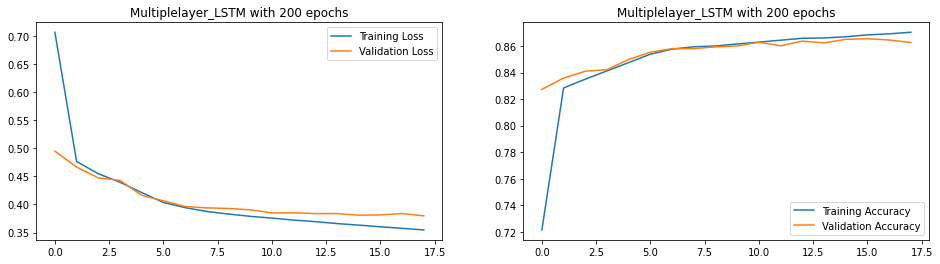

In [19]:
result_mLSTM = compile_train_model(Multiplelayer_LSTM, 200)

In [20]:
result_mLSTM['vocab_size'] = VOCAB_SIZE 
result_mLSTM['num_words'] = num_words 
result_mLSTM['num_articles'] = num_articles
result_mLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_mLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer LSTM']   
result_mLSTM.insert(loc=0, column='Model', value=new_col)

In [21]:
assignment_result_table = assignment_result_table.append(result_mLSTM,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


### Bidirectional LSTM

Epoch 1/200
1782/1782 [==============================] - 268s 145ms/step - loss: 0.7130 - accuracy: 0.7234 - val_loss: 0.4626 - val_accuracy: 0.8417
Epoch 2/200
1782/1782 [==============================] - 257s 144ms/step - loss: 0.4349 - accuracy: 0.8463 - val_loss: 0.4732 - val_accuracy: 0.8307
Epoch 3/200
1782/1782 [==============================] - 260s 146ms/step - loss: 0.4036 - accuracy: 0.8553 - val_loss: 0.4143 - val_accuracy: 0.8517
Epoch 4/200
1782/1782 [==============================] - 259s 145ms/step - loss: 0.3922 - accuracy: 0.8585 - val_loss: 0.4061 - val_accuracy: 0.8542
Epoch 5/200
1782/1782 [==============================] - 257s 144ms/step - loss: 0.3846 - accuracy: 0.8605 - val_loss: 0.4023 - val_accuracy: 0.8518
Epoch 6/200
1782/1782 [==============================] - 256s 143ms/step - loss: 0.3801 - accuracy: 0.8621 - val_loss: 0.3876 - val_accuracy: 0.8625
Epoch 7/200
1782/1782 [==============================] - 255s 143ms/step - loss: 0.3760 - accuracy: 0.8625

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

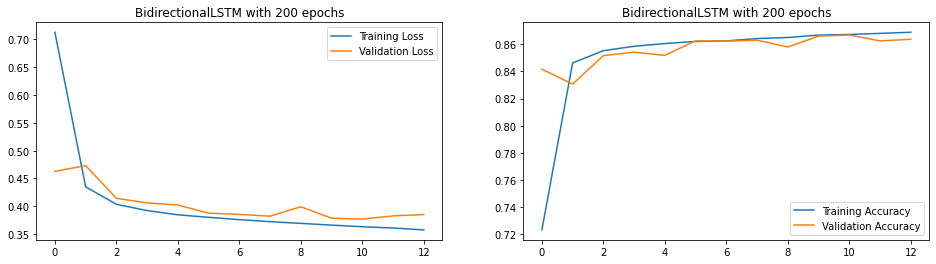

In [22]:
result_BiLSTM = compile_train_model(BidirectionalLSTM, 200)

In [23]:
result_BiLSTM['vocab_size'] = VOCAB_SIZE 
result_BiLSTM['num_words'] = num_words 
result_BiLSTM['num_articles'] = num_articles
result_BiLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_BiLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Bidirectional LSTM']   
result_BiLSTM.insert(loc=0, column='Model', value=new_col)

In [24]:
assignment_result_table = assignment_result_table.append(result_BiLSTM,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


### Multiplelayer Bidirectional LSTM

Epoch 1/200
1782/1782 [==============================] - 486s 262ms/step - loss: 0.6529 - accuracy: 0.7494 - val_loss: 0.4554 - val_accuracy: 0.8430
Epoch 2/200
1782/1782 [==============================] - 470s 263ms/step - loss: 0.4487 - accuracy: 0.8380 - val_loss: 0.4488 - val_accuracy: 0.8418
Epoch 3/200
119/119 [==============================] - 8s 70ms/step - loss: 0.4823 - accuracy: 0.8220
test set accuracy:  82.19736814498901


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

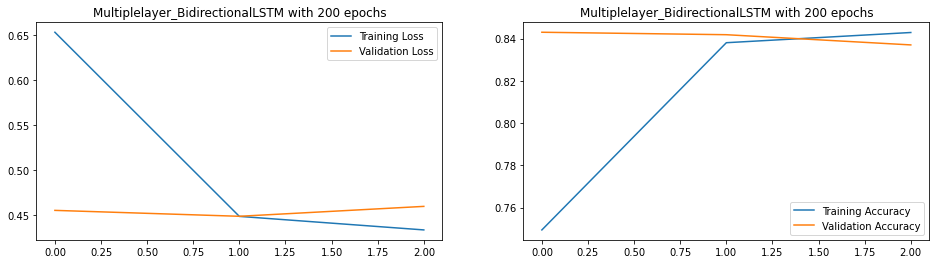

In [25]:
result_MBiLSTM = compile_train_model(Multiplelayer_BidirectionalLSTM, 200)

In [26]:
result_MBiLSTM['vocab_size'] = VOCAB_SIZE 
result_MBiLSTM['num_words'] = num_words 
result_MBiLSTM['num_articles'] = num_articles
result_MBiLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_MBiLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer Bidirectional LSTM']   
result_MBiLSTM.insert(loc=0, column='Model', value=new_col)

In [27]:
assignment_result_table = assignment_result_table.append(result_MBiLSTM,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


### Multiplelayer Bidirectional LSTM Dropout

Epoch 1/200
1782/1782 [==============================] - 681s 373ms/step - loss: 0.8119 - accuracy: 0.6564 - val_loss: 0.4970 - val_accuracy: 0.8303
Epoch 2/200
1782/1782 [==============================] - 666s 373ms/step - loss: 0.4936 - accuracy: 0.8346 - val_loss: 0.4494 - val_accuracy: 0.8443
Epoch 3/200
1782/1782 [==============================] - 654s 367ms/step - loss: 0.4459 - accuracy: 0.8493 - val_loss: 0.4072 - val_accuracy: 0.8587
Epoch 4/200
1782/1782 [==============================] - 656s 368ms/step - loss: 0.4273 - accuracy: 0.8547 - val_loss: 0.4010 - val_accuracy: 0.8570
Epoch 5/200
1782/1782 [==============================] - 659s 370ms/step - loss: 0.4169 - accuracy: 0.8572 - val_loss: 0.3939 - val_accuracy: 0.8605
Epoch 6/200
1782/1782 [==============================] - 663s 372ms/step - loss: 0.4096 - accuracy: 0.8594 - val_loss: 0.3907 - val_accuracy: 0.8600
Epoch 7/200
119/119 [==============================] - 9s 77ms/step - loss: 0.4242 - accuracy: 0.8432
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

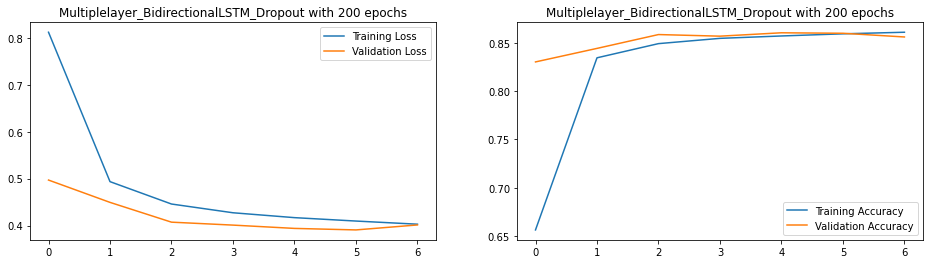

In [28]:
result_MBiDLSTM = compile_train_model(Multiplelayer_BidirectionalLSTM_Dropout, 200)

In [29]:
result_MBiDLSTM['vocab_size'] = VOCAB_SIZE 
result_MBiDLSTM['num_words'] = num_words 
result_MBiDLSTM['num_articles'] = num_articles
result_MBiDLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_MBiDLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer Bidirectional LSTM with Dropout']   
result_MBiDLSTM.insert(loc=0, column='Model', value=new_col)

In [30]:
assignment_result_table = assignment_result_table.append(result_MBiDLSTM,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


## Save data

In [31]:
assignment_result_table.to_pickle("/content/gdrive/My Drive/Colab Notebooks/resultsC.pkl") 
assignment_result_table.to_csv("/content/gdrive/My Drive/Colab Notebooks/resultsC.csv") 